In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
import h5py
import seaborn as sns
from scipy.stats import gmean
from matplotlib.image import NonUniformImage

In [3]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.cosmology import z_at_value
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)

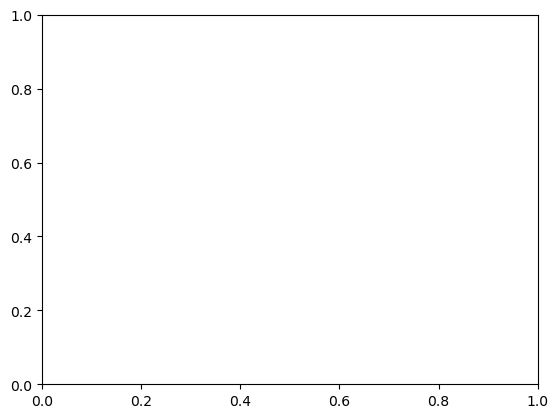

In [4]:


def x_mean_plotter(x, y, xbins=10, color='red', marker='o', plt_type=True, xgmean=True, ygmean=True, plot=True):
    
    start = min(x)
    stop = max(x)
    
    if xgmean:
        values = np.logspace(np.log10(start), np.log10(stop), xbins)
    else:
        values = np.linspace(start, stop, xbins)
    x_mean = []
    y_mean = []

    for i in range(len(values)-1):
        mask_x = ((x > values[i]) & (x < values[i+1]))
        x_slice = values[i:i+2]
        if xgmean:
            x_mean.append(gmean(x_slice))
        else:
            x_mean.append(np.mean(x_slice))
        if ygmean:   
            y_mean.append(gmean(y[mask_x]))
        else:
            y_mean.append(np.mean(y[mask_x]))
        if plot:
            if plt_type:
                plt.plot(x_mean, y_mean, color=color, marker=marker)
            else:
                plt.scatter(x_mean, y_mean, color=color, marker=marker)

    return x_mean, y_mean


In [5]:
def y_mean_plotter(x, y, ybins=10, color='orange', marker='o', plt_type=True, xgmean=True, ygmean=True, plot=True):
    
    start = min(y)
    stop = max(y)
    
    if ygmean:
        values = np.logspace(np.log10(start), np.log10(stop), ybins)
    else:
        values = np.linspace(start, stop, ybins)
    x_mean = []
    y_mean = []

    for i in range(len(values)-1):
        mask_y = ((y > values[i]) & (y < values[i+1]))
        y_slice = values[i:i+2]
        if ygmean:
            y_mean.append(gmean(y_slice))
        else:
            y_mean.append(np.mean(y_slice))
        if xgmean:   
            x_mean.append(gmean(x[mask_y]))
        else:
            x_mean.append(np.mean(x[mask_y]))
        if plot:
            if plt_type:
                plt.plot(x_mean, y_mean, color=color, marker=marker)
            else:
                plt.scatter(x_mean, y_mean, color=color, marker=marker)

    return x_mean, y_mean


In [6]:
def gw_calc(M_1, M_2,z=0.0001):
    M=M_1+M_2
    M_o=1
    mu=(M_1*M_2)**(3/5)/M**(1/5)
    d_l=cosmo.luminosity_distance(z).value
    pi=scipy.constants.pi
    f_c=3.9*(M/(10**4*M_o))**-1*(1+z)**-1
    h_c=8/(10**(1/2))*(mu)**(5/3)/(d_l*3.086e22)*(pi*f_c)**(2/3)
    return f_c, h_c, mu
 


In [7]:

lisa_f = []
lisa_h = []
for line in open('LISAstrain.txt', 'r'):
    lines = [i for i in line.split()]
    lisa_f.append(float(lines[0]))
    lisa_h.append(float(lines[1]))


In [12]:
def snr_calc(f_c, h_c, lisa_f=lisa_f, lisa_h=lisa_h):
    
    h_interp= np.interp(f_c, lisa_f, lisa_h)
    snr=h_c/h_interp
    return snr

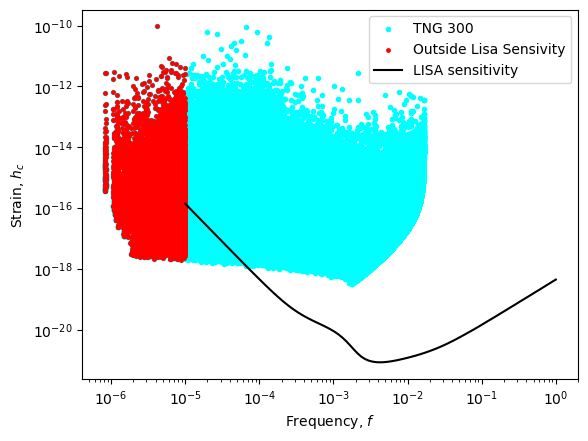

In [8]:

    
merger_file="blackhole_mergers_tng300.hdf5"
merger_data=h5py.File(merger_file, 'r')
M_1=np.maximum(merger_data['mass_out'],merger_data['mass_in'])*1e10/.6774
M_2=np.minimum(merger_data['mass_out'],merger_data['mass_in'])*1e10/.6774
z=np.array(merger_data['time'])**(-1)-1
#M=M_1+M_2
#M_o=1
#mu=(M_1*M_2)**(3/5)/M**(1/5)
#d_l=cosmo.luminosity_distance(z).value
#pi=scipy.constants.pi
#f_c=3.9*(M/(10**4*M_o))**-1*(1+z)**-1
#h_c=8/(10**(1/2))*(mu)**(5/3)/(d_l*3.086e22)*(pi*f_c)**(2/3)
f_c, h_c, mu=gw_calc(M_1,M_2,z)



mask_outside=((np.min(lisa_f)>f_c) | (np.max(lisa_f)<f_c))
plt.scatter(f_c,h_c,label='TNG 300', c='cyan',marker='.')
plt.scatter(f_c[mask_outside],h_c[mask_outside], label='Outside Lisa Sensivity', c='red',s=6)


plt.xlabel('Frequency, $f$')
plt.ylabel('Strain, $h_c$')
#plt.yticks(y)
plt.plot(lisa_f, lisa_h, label='LISA sensitivity',c='black')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()


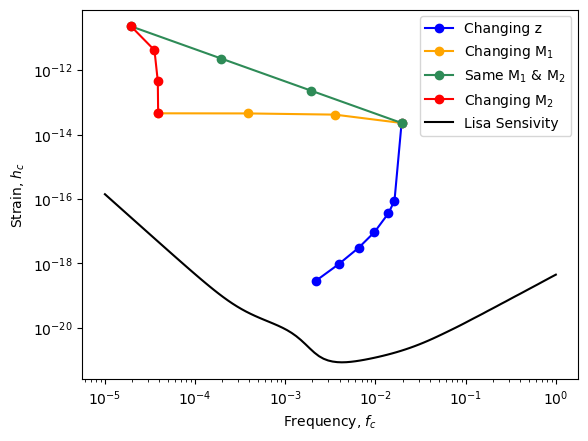

In [13]:
z_list=[0.001, 0.2, 0.4, 1, 2, 4, 8]
Mass_list=[1e6,1e7,1e8,1e9]
#curve1
h_1=[]
f_1=[]
for i in range(len(z_list)):
    f1, h1, mu1 = gw_calc(1e6, 1e6, z=z_list[i])
    h_1.append(h1)
    f_1.append(f1)
   
  
plt.plot(f_1,h_1,marker='o', label='Changing z', c='b')
#curve2
h_2=[]
f_2=[]
for i in range(len(Mass_list)):
    f2, h2, mu2 = gw_calc(Mass_list[i], 1e6,z=z_list[0])
    h_2.append(h2)
    f_2.append(f2)
plt.plot(f_2,h_2, marker='o', label='Changing M$_1$',c='orange')

#curve3
h_3=[]
f_3=[]
for i in range(len(Mass_list)):
    f3, h3, mu3 = gw_calc(Mass_list[i],Mass_list[i],z=z_list[0])
    h_3.append(h3)
    f_3.append(f3)
plt.plot(f_3, h_3, marker='o', label='Same M$_1$ & M$_2$',c='seagreen')
#curve4
h_4=[]
f_4=[]
for i in range(len(Mass_list)):
    f4, h4, mu4 = gw_calc(1e9,Mass_list[i], z=z_list[0])
    h_4.append(h4)
    f_4.append(f4)
plt.plot(f_4, h_4, marker='o', label='Changing M$_2$',c='r')


plt.plot(lisa_f,lisa_h,c='black',label='Lisa Sensivity')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency, $f_c$')
plt.ylabel('Strain, $h_c$')
plt.legend(loc='upper right')
plt.show()


[1.16060338e+07 5.23981839e+04 2.40296682e+04 7.92824682e+03
 3.20149329e+03 1.09503685e+03 1.76427320e+02]


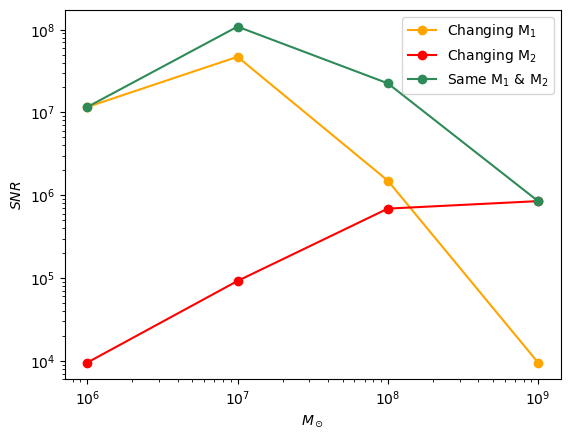

In [14]:
snr_z=snr_calc(f_1,h_1)
print(snr_z)
snr_M1=snr_calc(f_2,h_2)
snr_same=snr_calc(f_3,h_3)
snr_M2=snr_calc(f_4,h_4)

plt.plot(Mass_list,snr_M1, label='Changing M$_1$',c='orange',marker='o')
plt.plot(Mass_list,snr_M2, label='Changing M$_2$', c='r', marker='o')
plt.plot(Mass_list,snr_same, label='Same M$_1$ & M$_2$',c='seagreen', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_\odot$')
plt.ylabel('$SNR$')
plt.legend(loc='upper right')
plt.show()


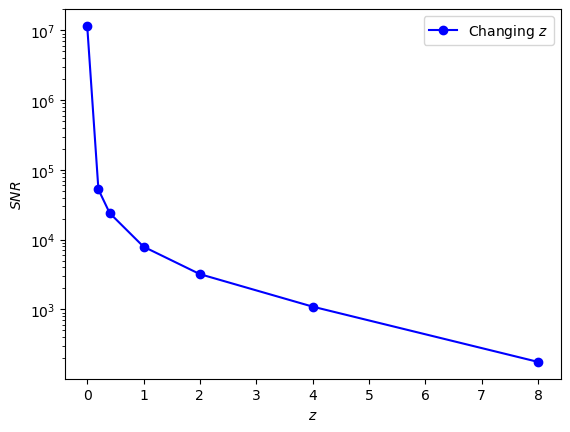

In [15]:
plt.plot(z_list,snr_z, label='Changing $z$',c='blue',marker='o')
plt.yscale('log')
plt.xlabel('$z$')
plt.ylabel('$SNR$')
plt.savefig('snrVtestz',dpi=400)
plt.legend(loc='upper right')
plt.show()


In [17]:
snr=snr_calc(f_c, h_c)
Mask=((np.min(lisa_f)<f_c) & (np.max(lisa_f)>f_c))
mask_outside=((np.min(lisa_f)>f_c) | (np.max(lisa_f)<f_c))
print(snr[Mask]) 



[1.06520453e+02 1.09627193e+02 1.20902266e+02 ... 2.28926507e+07
 2.18856361e+06 3.12000501e+04]


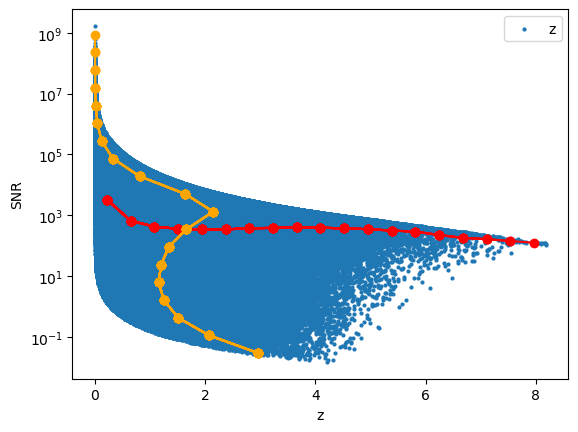

In [19]:
plt.scatter(z[Mask], snr[Mask], label='z', marker='o',s=4)
x_mean_plotter(z[Mask], snr[Mask],xgmean=False,xbins=20)
y_mean_plotter(z[Mask], snr[Mask],xgmean=False, ybins=20)

#plt.scatter(z[M_2>3e6], snr[M_2>3e6], label='z', marker='o',s=4, color='red')


plt.xlabel('z')
plt.ylabel('SNR')
plt.yscale('log')
plt.savefig('tng300-snrVz.png',dpi=400)
plt.legend(loc='upper right')
plt.show()

In [22]:
'Even though average snr of tng 50 & 300 vs z suggest that they should be around 1e3 but the test snr vs z suggest that they should decrese in high red shift.At first, we can see a sudden decrease at low redshift but the the average redshift is almost same'


'Even though average snr of tng 50 & 300 vs z suggest that they should be around 1e3 but the test snr vs z suggest that they should decrese in high red shift.At first, we can see a sudden decrease at low redshift but the the average redshift is almost same'

In [ ]:
mask_z_2to4=

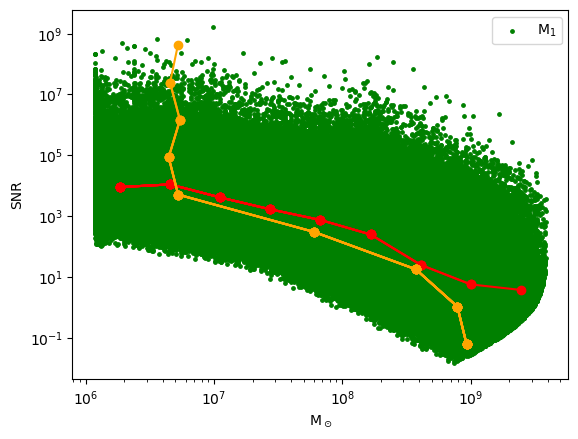

In [23]:
plt.scatter(M_1[Mask], snr[Mask], c='g', label='M$_1$', marker='o', s=6)
x_mean_plotter(M_1[Mask], snr[Mask])
y_mean_plotter(M_1[Mask], snr[Mask])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('M$_\odot$')
plt.ylabel('SNR')
plt.legend(loc='upper right')
plt.show()

In [29]:
max(M_1)



45895333623.7594

In [9]:
'$there are vertical straght lines, at the begining when the simulation puts the the blackhole they merge with some the equal mass, and we can see the second vertical line for that. WE can see some vertical lines in the end of the simulation, which represent big blackholes, as after their mergers their mass does not change that much$' 

'$there are vertical straght lines, at the begining when the simulation puts the the blackhole they merge with some the equal mass, and we can see the second vertical line for that. WE can see some vertical lines in the end of the simulation, which represent big blackholes, as after their mergers their mass does not change that much$'

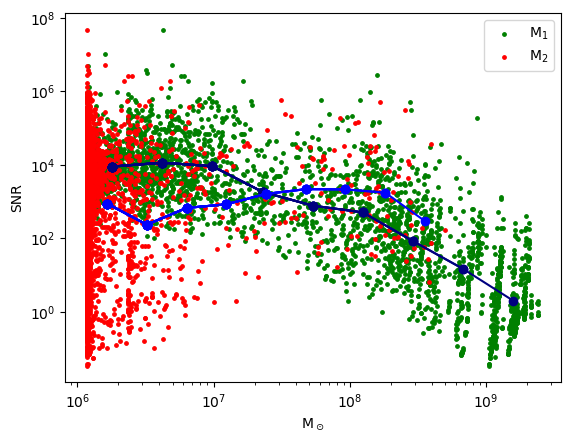

In [38]:

plt.scatter(M_1[Mask], snr[Mask], c='g', label='M$_1$', marker='o', s=6)
x_mean_plotter(M_1[Mask], snr[Mask],color='navy')

plt.scatter(M_2[Mask], snr[Mask], c='r', label='M$_2$', marker='o', s=6)
x_mean_plotter(M_2[Mask], snr[Mask],color='blue')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('M$_\odot$')
plt.ylabel('SNR')
plt.legend(loc='upper right')
plt.show()


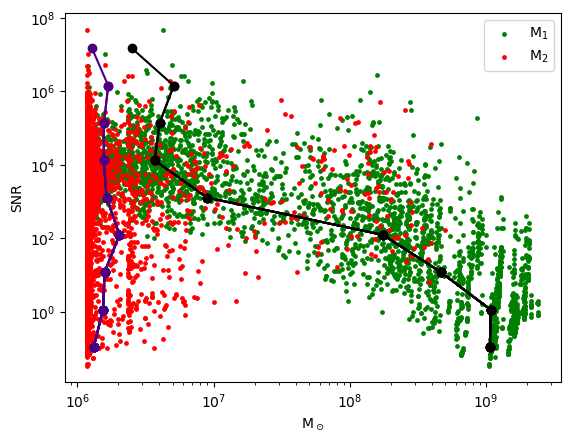

In [40]:
plt.scatter(M_1[Mask], snr[Mask], c='g', label='M$_1$', marker='o', s=6)
y_mean_plotter(M_1[Mask], snr[Mask],color='black')
plt.scatter(M_2[Mask], snr[Mask], c='r', label='M$_2$', marker='o', s=6)
y_mean_plotter(M_2[Mask], snr[Mask],color='indigo')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('M$_\odot$')
plt.ylabel('SNR')
plt.legend(loc='upper right')
plt.show()

In [41]:
'$there are vertical straght lines, at the begining when the simulation puts the the blackhole they merge with some the equal mass, and we can see the second vertical line for that$'

'$there are vertical straght lines, at the begining when the simulation puts the the blackhole they merge with some the equal mass, and we can see the second vertical line for that$'

In [43]:
'Average snr at any redshift is around 1e3'

'Average snr at any redshift is around 1e3'

In [44]:
#we can see a upper & lower limit of the function

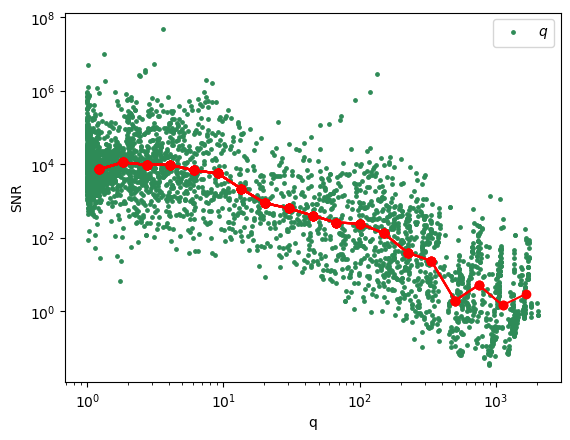

In [45]:
q=M_1/M_2
plt.scatter(q[Mask], snr[Mask], c='seagreen', label='$q$', marker='o', s=6)

x_mean_plotter(q[Mask], snr[Mask], xbins=20)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('q')
plt.ylabel('SNR')
#plt.scatter(values, np.ones(len(values))*1e4, color='yellow')
plt.legend(loc='upper right')
plt.show()


In [46]:
#It lools similar to M1 vs SNR graph.Dont know why?



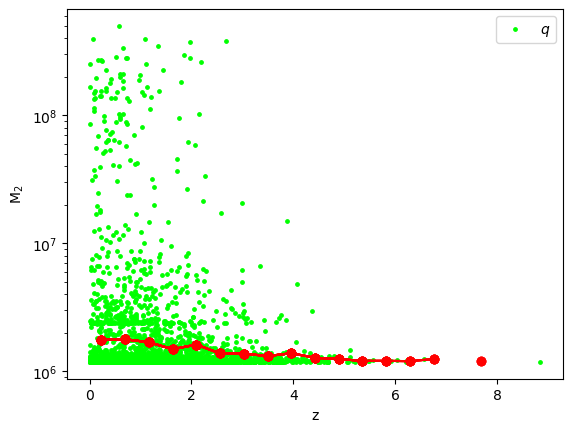

In [47]:
plt.scatter( z[Mask],M_2[Mask], c='lime', label='$q$', marker='o', s=6)
x_mean_plotter(z[Mask],M_2[Mask], xbins=20, xgmean=False)


plt.yscale('log')

plt.xlabel('z')
plt.ylabel('M$_2$')
plt.legend(loc='upper right')
plt.show()


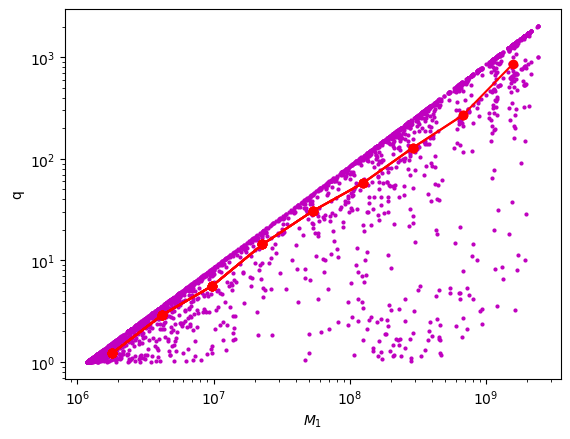

In [48]:
#plt.figure(figsize=[10,8])
plt.scatter(M_1[Mask],q[Mask], c='m', marker='o', s=4)
x_mean_plotter(M_1[Mask],q[Mask])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$M_1$')
plt.ylabel('q')
plt.savefig('test.png',dpi=400)

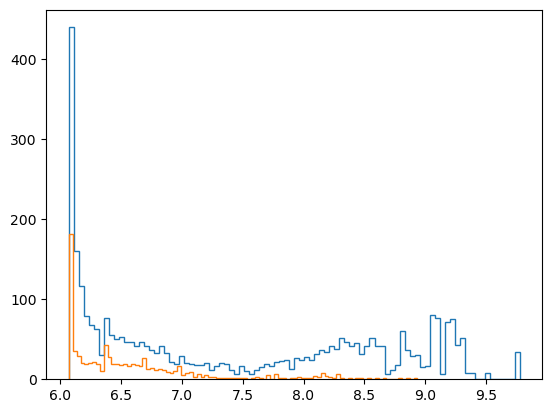

In [49]:
histdata =plt.hist(np.log10(M_1), bins=90, histtype='step', density=False)
histdata2 =plt.hist(np.log10(M_1[snr > 10000]), bins=90, histtype='step', density=False)

#sns.kdeplot(np.log10(M_2),
#   fill=True, common_norm=False,
#   alpha=.5, linewidth=0)
#histdata2 =plt.hist(np.log10(M_1[0:300]), bins=20, histtype='step', density='true')

#plt.plot(histdata[1][1:21], histdata[0][0:20])

In [50]:
print(np.log10(min(M_2)))

6.072187427588813


In [51]:
print(histdata[0])
print(histdata[1])

[440. 160. 116.  79.  68.  63.  30.  77.  55.  50.  53.  47.  47.  41.
  47.  42.  37.  33.  41.  33.  22.  19.  29.  20.  19.  18.  18.  20.
  11.  16.  20.  19.  11.   7.  17.  10.   7.  11.  15.  19.  17.  21.
  23.  24.  13.  26.  24.  28.  24.  32.  37.  34.  41.  38.  52.  47.
  41.  45.  32.  42.  51.  42.  42.   6.  12.  18.  60.  36.  29.  30.
  15.  16.  80.  76.   7.  72.  75.  43.  52.   8.   8.   0.   0.   8.
   0.   0.   0.   0.   0.  34.]
[6.07224478 6.11341165 6.15457851 6.19574537 6.23691223 6.2780791
 6.31924596 6.36041282 6.40157968 6.44274655 6.48391341 6.52508027
 6.56624713 6.607414   6.64858086 6.68974772 6.73091458 6.77208145
 6.81324831 6.85441517 6.89558203 6.93674889 6.97791576 7.01908262
 7.06024948 7.10141634 7.14258321 7.18375007 7.22491693 7.26608379
 7.30725066 7.34841752 7.38958438 7.43075124 7.47191811 7.51308497
 7.55425183 7.59541869 7.63658556 7.67775242 7.71891928 7.76008614
 7.80125301 7.84241987 7.88358673 7.92475359 7.96592046 8.00708732
 8.0482

In [52]:
print(len(histdata[1]), len(histdata[0]))

91 90


<Axes: ylabel='Density'>

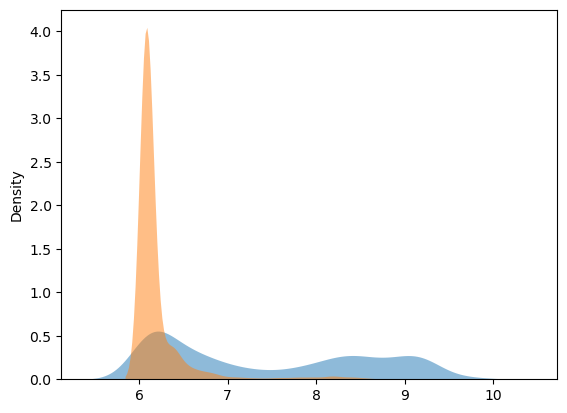

In [53]:
sns.kdeplot(np.log10(M_1),fill=True, common_norm=False,alpha=.5, linewidth=0)
sns.kdeplot(np.log10(M_2),fill=True, common_norm=False,alpha=.5, linewidth=0)


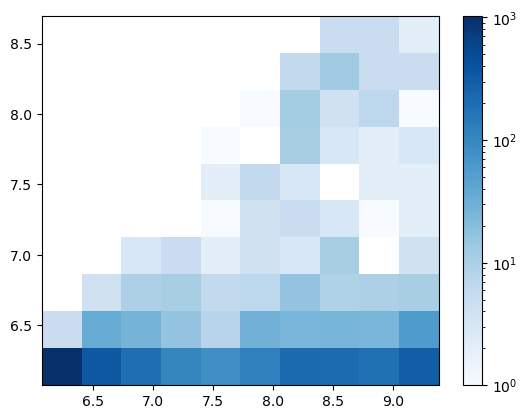

In [54]:
plt.hist2d(np.log10(M_1[Mask]),np.log10(M_2[Mask]), bins=10, density=False, cmap='Blues',norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

<Axes: >

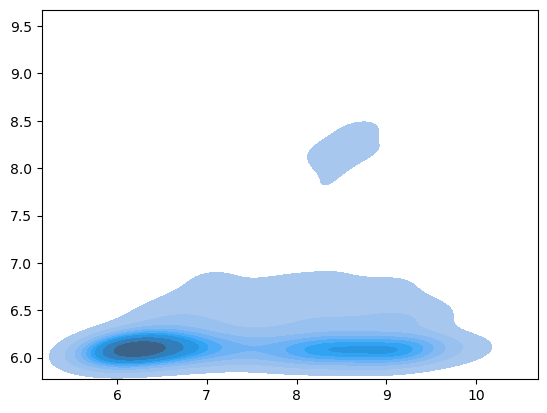

In [55]:
sns.kdeplot(x=np.log10(M_1),y=np.log10(M_2), fill=True)
#plt.show()

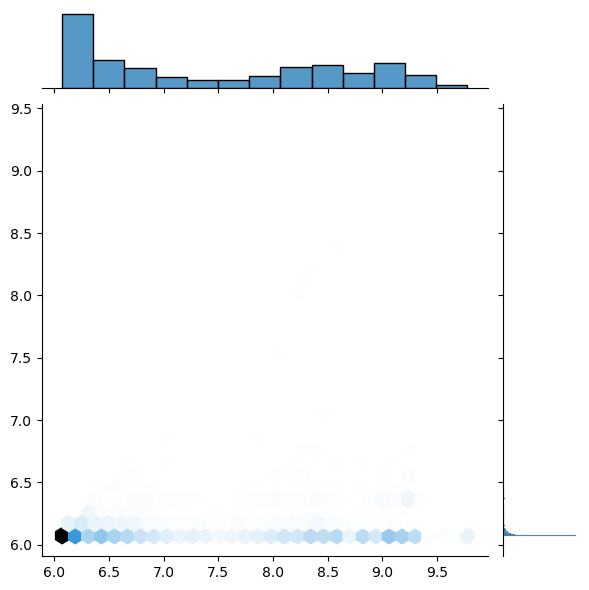

In [56]:
sns.jointplot(x=np.log10(M_1),y=np.log10(M_2), kind='hex')


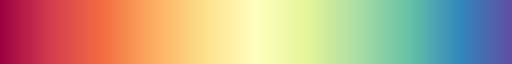

In [57]:
sns.color_palette("Spectral", as_cmap=True)

In [58]:
#Mean
#for i in range(len)

Text(0, 0.5, 'Number Of Mergers')

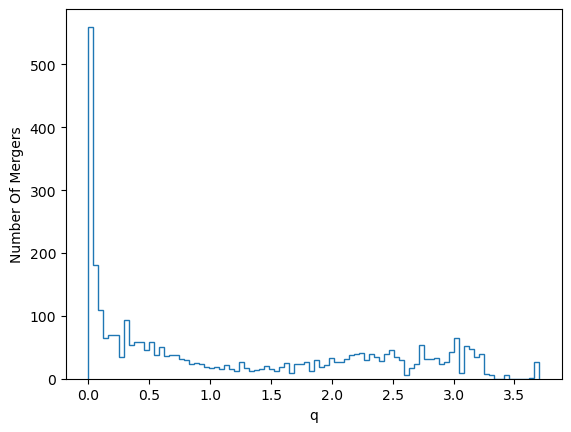

In [59]:
histdata =plt.hist(np.log10(q), bins=90, histtype='step', density=False)

plt.xlabel('q')
plt.ylabel('Number Of Mergers')

Text(0, 0.5, 'Number Of Mergers')

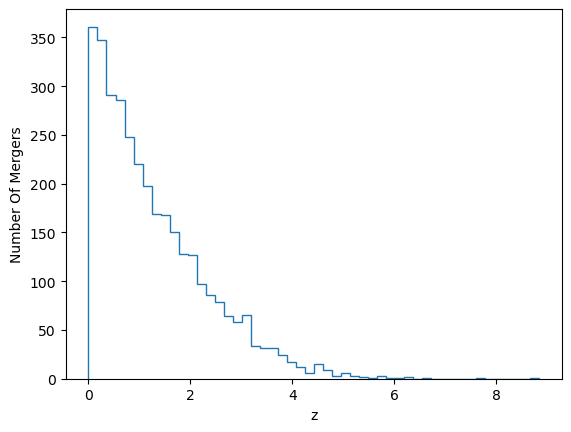

In [60]:
histdata =plt.hist(z, bins=50, histtype='step', density=False)
plt.xlabel('z')
plt.ylabel('Number Of Mergers')

In [61]:
'we can see that most blackhole mergers happened when the redshift is low, which is understandable '

'we can see that most blackhole mergers happened when the redshift is low, which is understandable '

<Axes: ylabel='Density'>

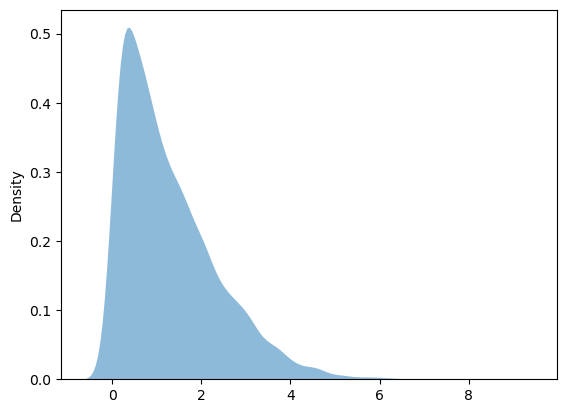

In [62]:
sns.kdeplot(z,fill=True, common_norm=False,
   alpha=.5, linewidth=0)

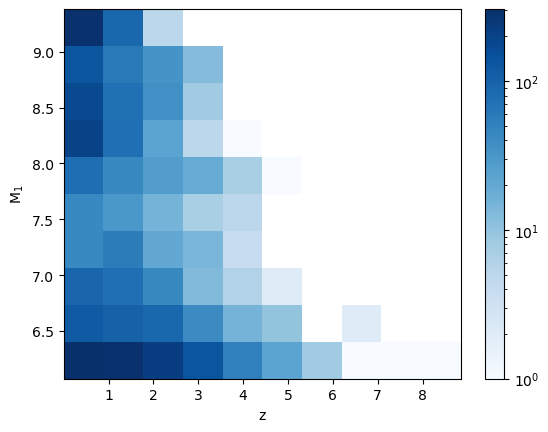

In [63]:
plt.hist2d(z[Mask],np.log10(M_1[Mask]), bins=10, density=False, cmap='Blues',norm=matplotlib.colors.LogNorm())
plt.xlabel('z')
plt.ylabel('M$_1$')
plt.colorbar()
plt.show()

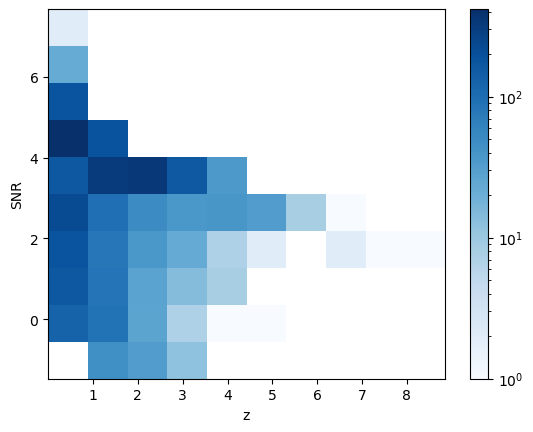

In [64]:
plt.hist2d(z[Mask],np.log10(snr[Mask]), bins=10, density=False, cmap='Blues',norm=matplotlib.colors.LogNorm())
plt.xlabel('z')
plt.ylabel('SNR')
plt.colorbar()
plt.show()

[1897051.3903121825, 4894943.916601749, 12630377.895420874, 32590045.667343497, 84091789.28720742, 216981255.4945257, 559874699.2429938, 1444639437.3468874, 3727589595.957358]


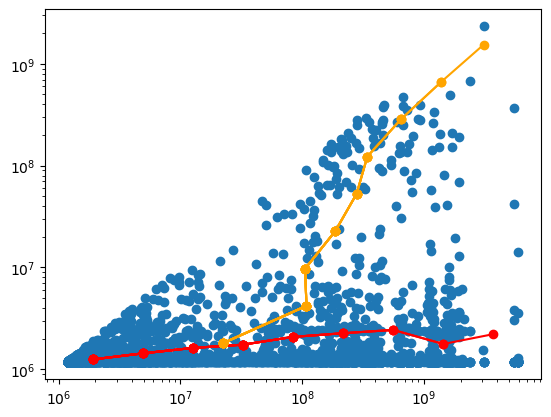

In [67]:
plt.scatter(M_1,M_2)
meanx, meany=x_mean_plotter(M_1,M_2)
y_mean_plotter(M_1,M_2)
plt.xscale('log')
plt.yscale('log')
print(meanx)

In [68]:
#np.save('snr_50.npy', snr_50)

##Later on:
#snr_50=np.load('snr_50.npy')

Text(0, 0.5, 'Number of Mergers')

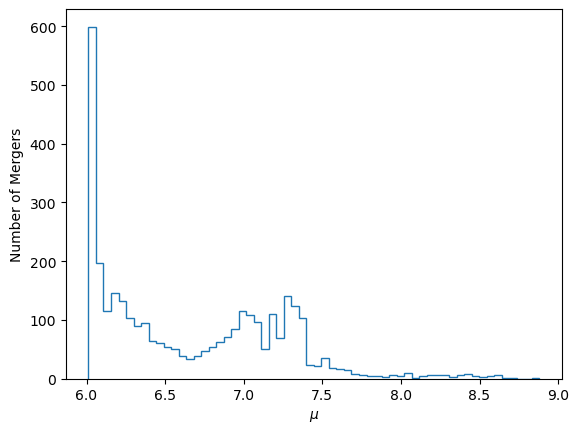

In [69]:
histdata =plt.hist(np.log10(mu[Mask]), bins=60, histtype='step', density=False)
plt.xlabel('$\mu$')
plt.ylabel('Number of Mergers')


Text(0, 0.5, 'Number of Mergers')

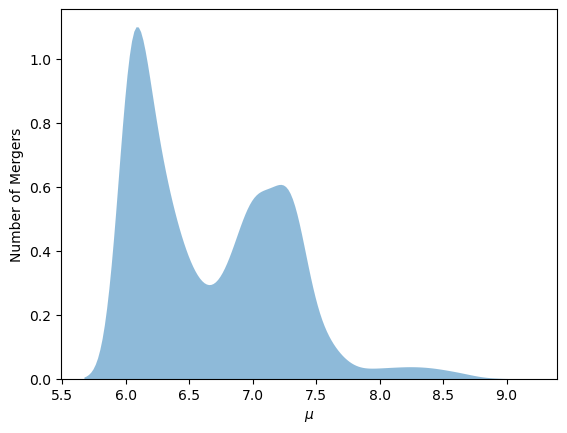

In [70]:
sns.kdeplot(np.log10(mu[Mask]),fill=True, common_norm=False,alpha=.5, linewidth=0)
plt.xlabel('$\mu$')
plt.ylabel('Number of Mergers')

In [71]:
#mu=(M_1*M_2)**(3/5)/M**(1/5)

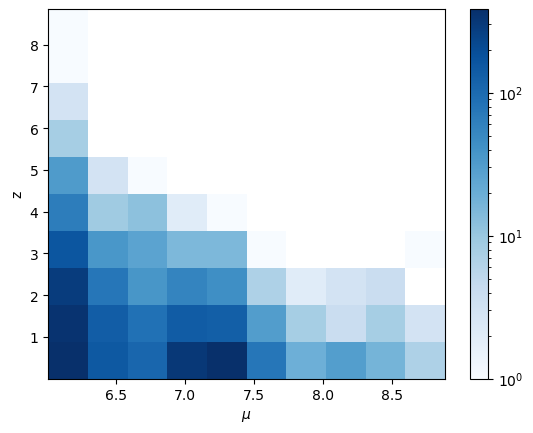

In [72]:
plt.hist2d(np.log10(mu[Mask]),z[Mask], bins=10, density=False, cmap='Blues',norm=matplotlib.colors.LogNorm())
plt.xlabel('$\mu$')
plt.ylabel('z')
plt.colorbar()
plt.show()

C:\Users\karma\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\karma\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'z')

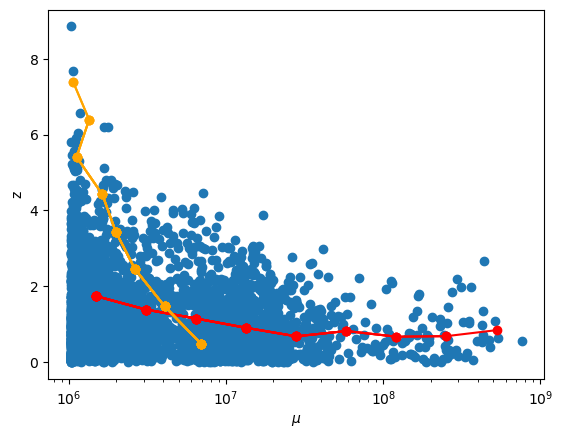

In [73]:
plt.scatter(mu[Mask], z[Mask])

x_mean_plotter(mu[Mask],z[Mask],ygmean=False)
y_mean_plotter(mu[Mask],z[Mask],ygmean=False)
plt.xscale('log')
plt.xlabel('$\mu$')
plt.ylabel('z')

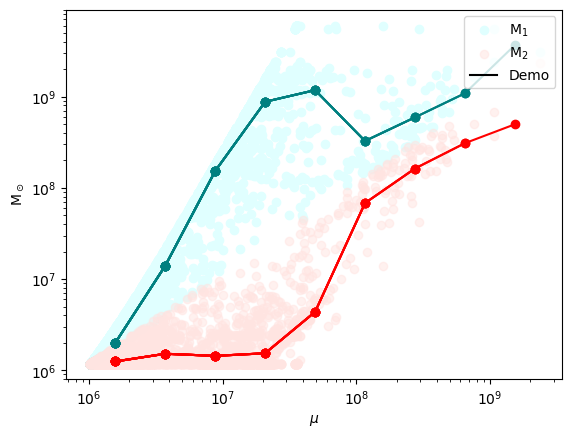

In [74]:
plt.scatter(mu,M_1, color='lightcyan',label='M$_1$')
x_mean_plotter(mu,M_1, color='teal')
plt.scatter(mu,M_2, alpha=.5, color='mistyrose',label='M$_2$')
x_mean_plotter(mu,M_2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\mu$')
plt.ylabel('M$_\odot$')
plt.ylim(8e5,9e9)
plt.plot([1e6,1e7], [1e10,1e10], color='black', label='Demo')

plt.legend(loc='upper right')


Text(0, 0.5, 'SNR')

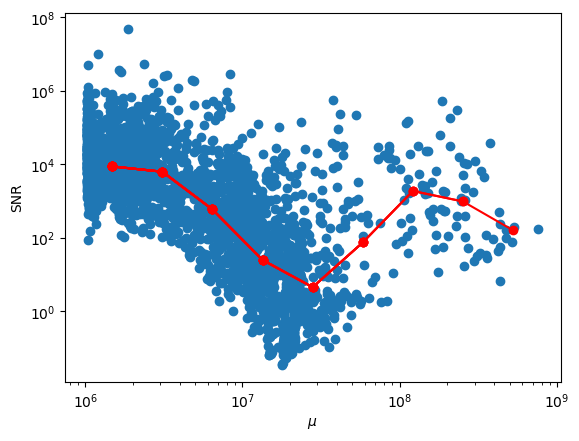

In [75]:
plt.scatter(mu[Mask],snr[Mask])
x_mean_plotter(mu[Mask],snr[Mask])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\mu$')
plt.ylabel('SNR')

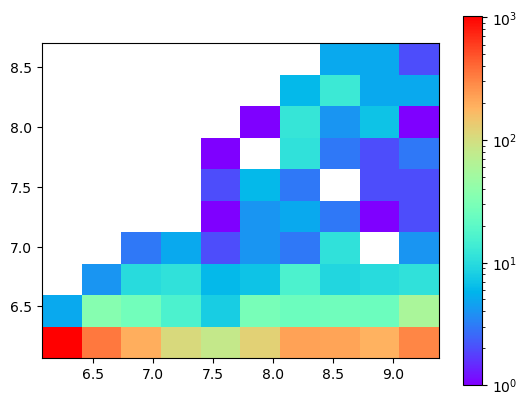

In [76]:
#plt.figure(figsize=(9,15))
#Histogram averaging for SNR
H_num, xedges, yedges = np.histogram2d(np.log10(M_1[Mask]), np.log10(M_2[Mask]), bins=(10,10))
H_z, xedges, yedges = np.histogram2d(np.log10(M_1[Mask]), np.log10(M_2[Mask]), bins=(xedges, yedges), weights=z[Mask])
H_num=H_num.T
H_z=H_z.T

#Regular histogram:
plt.imshow(H_num, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
           cmap='rainbow', norm=matplotlib.colors.LogNorm())
#Weighted histogram
#plt.imshow(H_snr/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#plt.xscale('log')
#plt.yscale('log')
plt.colorbar()

C:\Users\karma\AppData\Local\Temp\ipykernel_3136\2273650970.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Spectral',norm=matplotlib.colors.LogNorm())


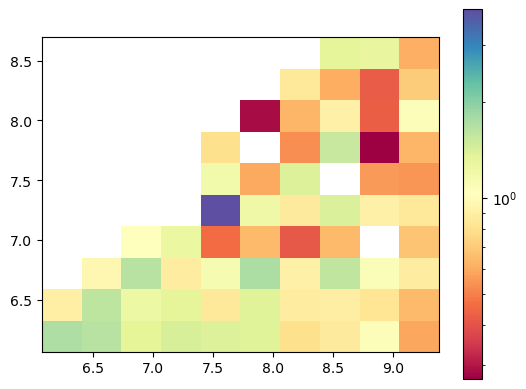

In [77]:
plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Spectral',norm=matplotlib.colors.LogNorm())
plt.colorbar()

In [78]:
print(H_z/H_num)

[[1.72454995 1.64274927 1.3406538  1.42674101 1.40150712 1.37317967
  0.79257405 0.86220203 1.06370955 0.58895845]
 [0.90349143 1.59845626 1.22619037 1.32095426 0.8560662  1.35988001
  0.88021431 0.89556472 0.83164296 0.6467268 ]
 [       nan 0.96439636 1.65420842 0.88550873 1.12708249 1.74007978
  0.90933061 1.58786497 1.07113619 0.88781642]
 [       nan        nan 1.01674525 1.24935226 0.46115881 0.64388752
  0.4118824  0.64813689        nan 0.67927101]
 [       nan        nan        nan        nan 3.87876272 1.20050055
  0.86305242 1.40568058 0.91447651 0.84731412]
 [       nan        nan        nan        nan 1.18131149 0.59795181
  1.40121023        nan 0.55870843 0.54753631]
 [       nan        nan        nan        nan 0.7951839         nan
  0.53224144 1.5314815  0.27189887 0.63636283]
 [       nan        nan        nan        nan        nan 0.28766906
  0.63298753 0.90833655 0.42845282 1.06449914]
 [       nan        nan        nan        nan        nan        nan
  0.84855803

C:\Users\karma\AppData\Local\Temp\ipykernel_3136\2209997513.py:1: RuntimeWarning: invalid value encountered in divide
  print(H_z/H_num)


In [ ]:
Histogram:

Bin_edges_x=[6, 6.1, 6.2, …]

Bin_edges_y=[6, 6.1, 6.2, …]

Bin_edges_z=[0, 0.1, 0.2, …]

For i in range(len(bin_edges_x)-1):

          For j in range(len(bin_edges_y)-1):

                   For k in range(len(bin_edges_z)-1):

                              Mask=((M1 > bin_edges_x[i]) & (M1 <= bin_edges_x[i+1]) & (M2 > bin_edges_y[j]) & (M2 <= bin_edges_y[j+1]) & (z > bin_edges_z[k]) & (z <= bin_edges_z[k+1]))

                    #Hist_count[i]=len(M1[Mask])

                    Hist_averagez[i]=np.mean(SNR[Mask])

 

i=0

Mask=((M1 > bin_edges[0]) & (M1 <= bin_edges[1]))

i=1

Mask=((M1 > bin_edges[1]) & (M1 <= bin_edges[2]))

 

For I in [0,1,2,3]:

          For j in [0.1, 1.1, 2.1, 3.1]:

                   Print(I,j)

 

0,0.1

0,1.1

0,2.1

0,3.1

1,0.1

1,1.1

 

Curve 1: M1=1e6, M2=1e6, z=[…]

Curve 2: M1=[…], M2=1e6, z=0

Curve 3: M1=M2=[…], z=0

Curve 4: M1=1e10, M2=[….], z=0

 

 

 

 

Z_list=[0, 0.2, 0.5, 1, 2, 4]

Mass_list=[1e6,1e7,1e8,1e9,1e10]

 

Vary M1:

For mass_counter in range(len(Mass_list)):

          H,f=calc_GW(Mass_list[mass_counter], Mass_list[0], z_list[0])

 

 

Calc_SNR(h,f):

          Equations…

          Return snr

 

 

Print(calc_snr(calc_GW(…))